In [1]:
%load_ext autoreload
%autoreload 2
import sys
#sys.path.insert(1, '/home/ximo/Documents/GitHub/skforecast')
%config Completer.use_jedi = False

## Libraries

In [2]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

## Data

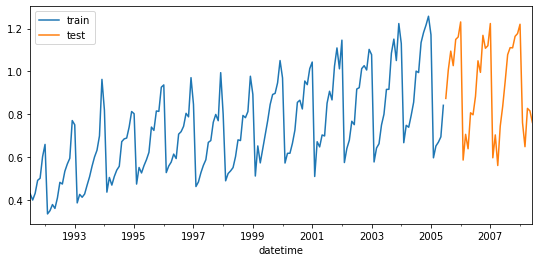

In [3]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Split train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();

## Train forecaster

In [5]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = Ridge(),
                    steps     = 36,
                    lags      = 15
                )

forecaster.fit(y=data_train)
forecaster

ForecasterAutoregMultiOutput 
Regressor: Ridge() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Window size: 15 
Maximum steps predicted: 36 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001} 
Creation date: 2022-01-02 16:27:25 
Last fit date: 2022-01-02 16:27:25 
Skforecast version: 0.4.2 

## Prediction

In [6]:
# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps)
predictions.head(3)

2005-07-01    0.952051
2005-08-01    1.004145
2005-09-01    1.114590
Freq: MS, Name: pred, dtype: float64

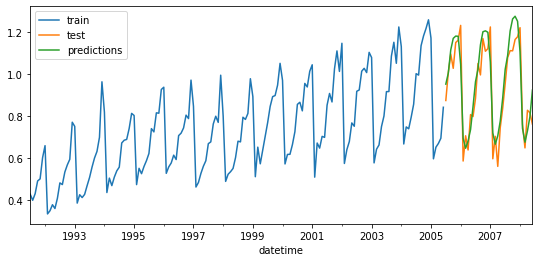

In [7]:
# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [9]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.008419597278831953


## Feature importance

Since `ForecasterAutoregMultiOutput` fits one model per step,it is necessary to specify from which model retrieve its feature importance.

In [11]:
print(forecaster.get_coef(step=1).to_markdown(index=False))

| feature   |       coef |
|:----------|-----------:|
| lag_1     |  0.139299  |
| lag_2     |  0.0510889 |
| lag_3     |  0.0441923 |
| lag_4     | -0.0198684 |
| lag_5     | -0.0179349 |
| lag_6     | -0.0132333 |
| lag_7     | -0.0210635 |
| lag_8     | -0.0125908 |
| lag_9     |  0.0119178 |
| lag_10    |  0.0205112 |
| lag_11    |  0.15403   |
| lag_12    |  0.551652  |
| lag_13    |  0.0575131 |
| lag_14    | -0.0710707 |
| lag_15    | -0.0352375 |


## Extract training matrix

Two steps are needed. One to create the whole training matrix and a second one to subset the data needed for each model (step).

In [12]:
X, y = forecaster.create_train_X_y(data_train)
# X and y to train model for step 1
X_1, y_1 = forecaster.filter_train_X_y_for_step(
                step    = 1,
                X_train = X,
                y_train = y,
            )

print(X_1.head(4).to_markdown(index=False))
print(y_1.head(4).to_markdown(index=False))

|    lag_1 |    lag_2 |    lag_3 |    lag_4 |    lag_5 |    lag_6 |    lag_7 |    lag_8 |    lag_9 |   lag_10 |   lag_11 |   lag_12 |   lag_13 |   lag_14 |   lag_15 |
|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|
| 0.534761 | 0.475463 | 0.483389 | 0.410534 | 0.361801 | 0.379808 | 0.351348 | 0.33622  | 0.660119 | 0.602652 | 0.502369 | 0.492543 | 0.432159 | 0.400906 | 0.429795 |
| 0.568606 | 0.534761 | 0.475463 | 0.483389 | 0.410534 | 0.361801 | 0.379808 | 0.351348 | 0.33622  | 0.660119 | 0.602652 | 0.502369 | 0.492543 | 0.432159 | 0.400906 |
| 0.595223 | 0.568606 | 0.534761 | 0.475463 | 0.483389 | 0.410534 | 0.361801 | 0.379808 | 0.351348 | 0.33622  | 0.660119 | 0.602652 | 0.502369 | 0.492543 | 0.432159 |
| 0.771258 | 0.595223 | 0.568606 | 0.534761 | 0.475463 | 0.483389 | 0.410534 | 0.361801 | 0.379808 | 0.351348 | 0.33622  | 0.660119 | 0.602652 | 0.502369 | 0.492543 